# This module Contains the Model to produce beeth music

## Imports 

In [1]:
# Standard libraries
import sys
import time
import random
import os

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pretty_midi
import numpy as np
from typing import Tuple, List

# Local imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.utils import *

## Logging

In [2]:
log = logger(True) ; log("logging in :)") 
log("This is a test log message.")

# Auto-reloading of modules in iPython
%load_ext autoreload
%autoreload 2

logging in :)
This is a test log message.


## Import Data

In [3]:
# Ruta absoluta a la carpeta con los archivos MIDI
midi_dir_path = '/home/alyonaivanova/personal/LSTM-Musician/Data/beeth'

# Cargar todos los archivos MIDI y extraer las características
all_music_data = load_all_midi_files(midi_dir_path)

Loading /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/beethoven_opus22_1.mid...
Loaded 2899 notes from /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/beethoven_opus22_1.mid
Loading /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/appass_1.mid...
Loaded 3207 notes from /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/appass_1.mid
Loading /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/pathetique_1.mid...
Loaded 2844 notes from /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/pathetique_1.mid
Loading /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/beethoven_opus10_1.mid...
Loaded 1441 notes from /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/beethoven_opus10_1.mid
Loading /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/beethoven_opus10_2.mid...
Loaded 915 notes from /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/beethoven_opus10_2.mid
Loading /home/alyonaivanova/personal/LSTM-Musician/Data/beeth/elise.mid...
Loaded 601 notes f

In [ ]:
# Supongamos que `all_music_data` contiene las características extraídas
# Extraer columnas individuales para análisis
pitch_data = all_music_data[:, 0]  # pitch
step_data = all_music_data[:, 1]   # step (tiempo entre notas)
duration_data = all_music_data[:, 2]  # duración de las notas
velocity_data = all_music_data[:, 3]  # velocidad (opcional)
# Imprimir estadísticas de las características
print("Pitch - min: {}, max: {}, mean: {}, std: {}".format(
    np.min(pitch_data), np.max(pitch_data), np.mean(pitch_data), np.std(pitch_data)))

print("Step - min: {}, max: {}, mean: {}, std: {}".format(
    np.min(step_data), np.max(step_data), np.mean(step_data), np.std(step_data)))

print("Duration - min: {}, max: {}, mean: {}, std: {}".format(
    np.min(duration_data), np.max(duration_data), np.mean(duration_data), np.std(duration_data)))

print("Velocity - min: {}, max: {}, mean: {}, std: {}".format(
    np.min(velocity_data), np.max(velocity_data), np.mean(velocity_data), np.std(velocity_data)))


Pitch - min: 30.0, max: 101.0, mean: 72.28124063530117, std: 9.958152334716386
Step - min: -3.0304053749999866, max: 185.37433224999882, mean: 0.20333806862821974, std: 1.2664905135428812
Duration - min: 0.006782941666664044, max: 9.5016013125, mean: 0.27572172985473786, std: 0.3892719602703576
Velocity - min: 15.0, max: 119.0, mean: 57.31785660773149, std: 16.174300788109306


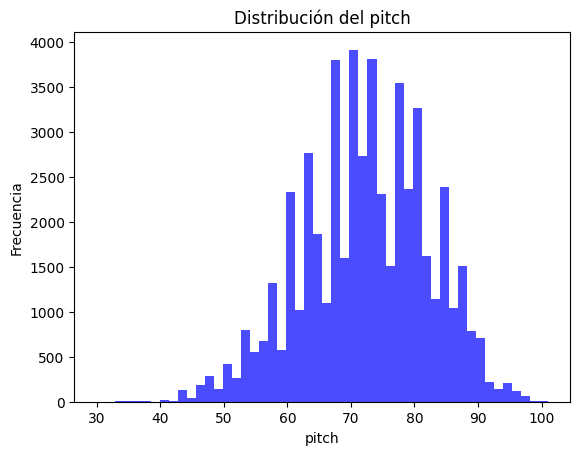

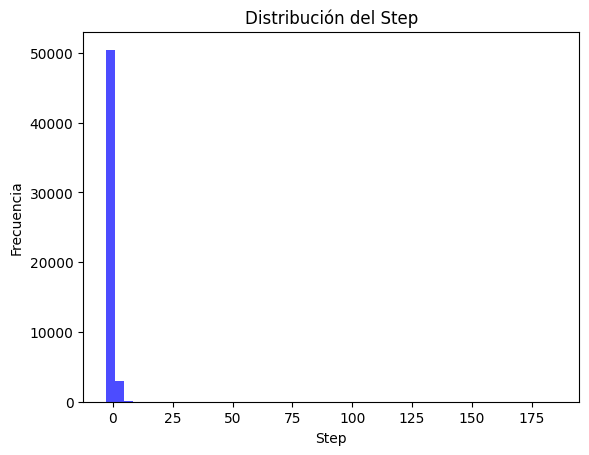

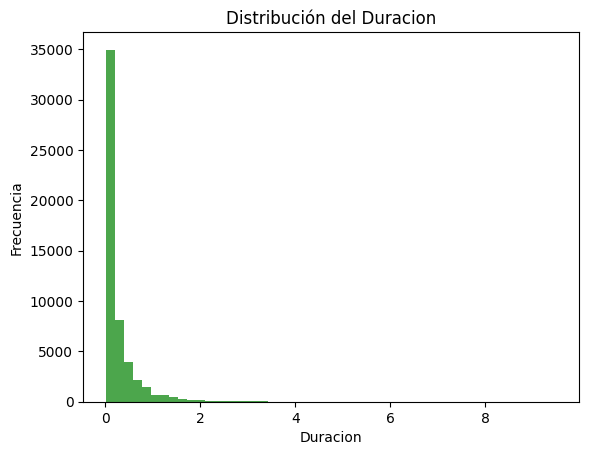

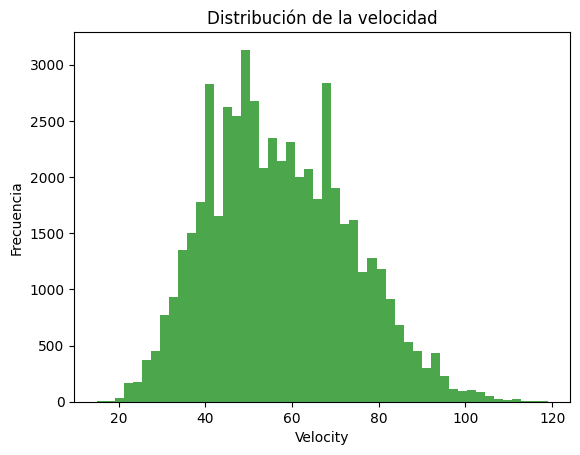

In [5]:
plt.hist(pitch_data, bins=50, color='blue', alpha=0.7)
plt.title('Distribución del pitch')
plt.xlabel('pitch')
plt.ylabel('Frecuencia')
plt.show()

plt.hist(step_data, bins=50, color='blue', alpha=0.7)
plt.title('Distribución del Step')
plt.xlabel('Step')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la distribución de la duración
plt.hist(duration_data, bins=50, color='green', alpha=0.7)
plt.title('Distribución del Duracion')
plt.xlabel('Duracion')
plt.ylabel('Frecuencia')
plt.show()

plt.hist(velocity_data, bins=50, color='green', alpha=0.7)
plt.title('Distribución de la velocidad')
plt.xlabel('Velocity')
plt.ylabel('Frecuencia')
plt.show()

De acuerdo con las estadísticas que has mostrado:

Pitch:

Min: 30.0, Max: 101.0
Media: 72.28, Desv. estándar: 9.95
Los valores de pitch están dentro del rango esperado (de 30 a 101). No parece haber valores extremos (outliers) problemáticos.
Step (tiempo entre notas):

Min: -3.03, Max: 185.37
Media: 0.20, Desv. estándar: 1.27
Aquí, el valor mínimo es negativo, lo cual puede ser inusual. Deberíamos verificar los datos que tienen pasos negativos (podría ser un error de extracción de datos). También hay una gran variabilidad, con un máximo de 185, lo que podría significar tiempos largos entre algunas notas.
Duration (duración de las notas):

Min: 0.0067, Max: 9.50
Media: 0.2757, Desv. estándar: 0.39
Las duraciones parecen razonables, aunque podríamos querer normalizar estos valores debido a la diferencia entre el mínimo y el máximo.
Velocity (fuerza de la nota):

Min: 15.0, Max: 119.0
Media: 57.31, Desv. estándar: 16.17
Estos valores también están dentro del rango esperado (de 15 a 119), lo que sugiere que los datos están en una escala razonable.
Recomendaciones:
Normalización: Dado que hay diferencias significativas en las escalas de estas características (por ejemplo, la step y duration tienen máximos muy altos en comparación con velocity y pitch), sería recomendable normalizar los datos.

Para normalizar, podemos aplicar Min-Max scaling como te mostré antes. Esto es especialmente importante en redes neuronales, ya que características en diferentes escalas pueden dificultar el aprendizaje.

Análisis de valores negativos en Step: Verifica si los valores negativos de step son un error. Si no tienen sentido para tu modelo (es decir, no deberías tener tiempos negativos entre las notas), podrías corregir o eliminar esos valores.

In [6]:
# Crear una copia de los datos originales antes de realizar cambios
all_music_data = np.copy(all_music_data)
# Función para normalizar entre 0 y 1 usando Min-Max Scaling
def normalize_data(data: np.ndarray) -> np.ndarray:
    data_min = data.min(axis=0)
    data_max = data.max(axis=0)
    # Evitar división por cero
    return (data - data_min) / (data_max - data_min + 1e-6)

# Normalizar los datos de música
all_music_data_normalized = normalize_data(all_music_data)

# Verificación rápida después de la normalización
print("Pitch normalizado - min: {}, max: {}".format(
    np.min(all_music_data_normalized[:, 0]), np.max(all_music_data_normalized[:, 0])))
print("Step normalizado - min: {}, max: {}".format(
    np.min(all_music_data_normalized[:, 1]), np.max(all_music_data_normalized[:, 1])))
print("Duration normalizado - min: {}, max: {}".format(
    np.min(all_music_data_normalized[:, 2]), np.max(all_music_data_normalized[:, 2])))
print("Velocity normalizado - min: {}, max: {}".format(
    np.min(all_music_data_normalized[:, 3]), np.max(all_music_data_normalized[:, 3])))


Pitch normalizado - min: 0.0, max: 0.9999999859154932
Step normalizado - min: 0.0, max: 0.9999999946922778
Duration normalizado - min: 0.0, max: 0.9999998946794078
Velocity normalizado - min: 0.0, max: 0.9999999903846155


Valores negativos en Step: El hecho de que haya 1869 valores negativos en step es preocupante. En general, los valores negativos para el tiempo entre notas no deberían existir, a menos que haya una justificación física o lógica para ello.

Posibles acciones para los valores negativos en Step:
Filtrar o corregir los valores negativos:

Si los valores negativos son incorrectos, podrías eliminarlos o transformarlos en valores positivos, dependiendo de si tienen una interpretación válida o no.
Sustituir por el valor absoluto:

Si quieres asegurarte de que step sea siempre positivo, podrías tomar el valor absoluto de step para corregir estos errores.

In [7]:
# Verificar si hay valores negativos en Step
step_data = all_music_data[:, 1]
negative_steps = step_data[step_data < 0]
print(f"Hay {len(negative_steps)} valores negativos en Step.")

Hay 1869 valores negativos en Step.


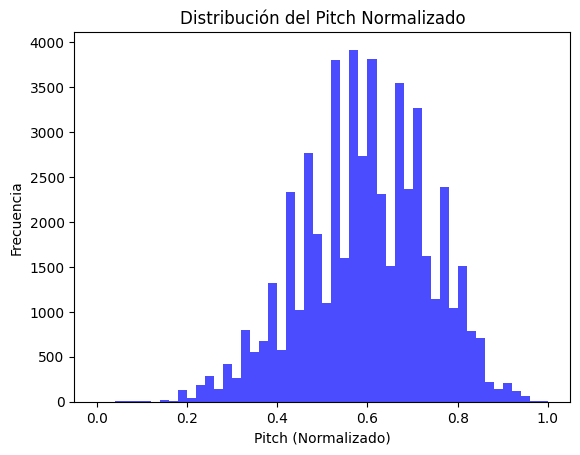

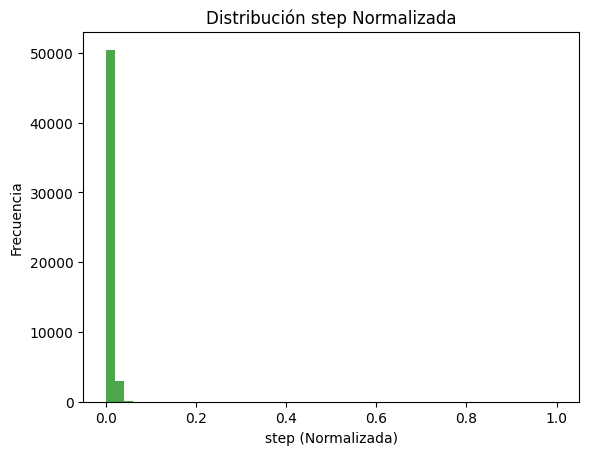

In [8]:
# Utilizar los datos normalizados para extraer las características
pitch_data_normalized = all_music_data_normalized[:, 0]  # pitch normalizado
step_data_normalized = all_music_data_normalized[:, 1]   # step normalizado
duration_data_normalized = all_music_data_normalized[:, 2]  # duración normalizada
velocity_data_normalized = all_music_data_normalized[:, 3]  # velocidad normalizada

# Visualizar la distribución del pitch (normalizado)
plt.hist(pitch_data_normalized, bins=50, color='blue', alpha=0.7)
plt.title('Distribución del Pitch Normalizado')
plt.xlabel('Pitch (Normalizado)')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la distribución de la duración (normalizada)
plt.hist(step_data_normalized, bins=50, color='green', alpha=0.7)  # Cambié alpha a 0.7 para que sea visible
plt.title('Distribución step Normalizada')
plt.xlabel('step (Normalizada)')
plt.ylabel('Frecuencia')
plt.show()


## model

In [9]:
# Función para dividir los datos en conjuntos de entrenamiento y validación
def split_train_val(data: np.ndarray, validation_size: float, random_seed: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Split the data into training and validation sets.

    Args:
        data (np.ndarray): The full dataset containing the musical features.
        validation_size (float): Fraction of data to be used for validation (between 0 and 1).
        random_seed (int): Seed for random number generator to ensure reproducibility.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The training data and validation data arrays.
    """
    num_samples: int = len(data)  # Total number of samples
    indices: List[int] = list(range(num_samples))  # Generate indices
    
    # Compute the splitting index
    split_idx: int = int(np.floor(validation_size * num_samples))
    
    # Shuffle the indices
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
    # Split the indices for training and validation
    train_indices = indices[split_idx:]
    val_indices = indices[:split_idx]
    
    # Split the actual data
    train_data = data[train_indices]
    val_data = data[val_indices]
    
    return train_data, val_data

# Verificamos si se han cargado los datos correctamente
if all_music_data is not None:
    # Dividir los datos en entrenamiento y validación usando los parámetros directamente
    validation_size = 0.20  # Usamos directamente el valor que necesitemos
    random_seed = 11
    train_data, val_data = split_train_val(all_music_data, validation_size, random_seed)

    # Mostrar la información del conjunto de datos
    train_len: int = len(train_data)
    val_len: int = len(val_data)
    total_len: int = len(all_music_data)

    # Logging para revisar
    print(f"Total samples: {total_len}")
    print(f"Training samples: {train_len}")
    print(f"Validation samples: {val_len}")

    # Verificación
    assert train_len + val_len == total_len, "El número total de muestras no coincide \
        con la suma de entrenamiento y validación."
else:
    print("No se cargaron datos de música.")


Total samples: 53392
Training samples: 42714
Validation samples: 10678


In [10]:
# Modify the get_config function to include the device
def get_config():
    config = {
        'save_every': 20,
        'seq_size': 25,
        'random_seed': 11,
        'validation_size': 0.20,
        'learning_rate': 1e-1,
        'n_epochs': 100,
        'num_layers': 4,
        'hidden_size': 250,
        'dropout_p': 0.1,
        'model_type': 'lstm',
        'batch_size': 150,
        'input_size': 4,
        'output_size': 4,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
    torch.manual_seed(config['random_seed'])
    return config

# Modify the create_model function to pass the device
def create_model(config):
    return MusicRNN(
        input_size=config['input_size'],
        hidden_size=config['hidden_size'],
        output_size=config['output_size'],
        model=config['model_type'],
        num_layers=config['num_layers'],
        dropout_p=config['dropout_p'],
        device=config['device']  # Pass the device to the model
    )

class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model='lstm', num_layers=4, dropout_p=0.1, device='cpu'):
        super(MusicRNN, self).__init__()
        self.model = model
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.device = device  # Add device parameter

        if self.model == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p)
        elif self.model == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p)
        else:
            raise NotImplementedError(f"Modelo '{self.model}' no soportado.")

        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, hidden):
        rnn_out, hidden = self.rnn(x, hidden)
        rnn_out = self.dropout(rnn_out)
        output = self.fc(rnn_out)
        return output, hidden
    
    def init_hidden(self, batch_size):
        # Ensure hidden states are initialized as 2D tensors
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # Move to GPU if available
        if next(self.parameters()).is_cuda:
            h0 = h0.cuda()
            c0 = c0.cuda()

        print(f"Initial hidden state h0 shape: {h0.shape}")
        print(f"Initial cell state c0 shape: {c0.shape}")
        
        return (h0, c0)

# Función para crear un lote de entrenamiento (batch) dinámico con el tamaño del lote
def train_batch(data: np.ndarray, batch_size: int, config: dict) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Crea un lote de entrenamiento con el tamaño del batch.
    """
    slice_len = config['seq_size']
    num_features = data.shape[1]
    batch_seq = torch.zeros(batch_size, slice_len, num_features)
    batch_target = torch.zeros(batch_size, slice_len, num_features)

    for idx in range(batch_size):
        seq, target = train_slice(data, slice_len=slice_len)
        batch_seq[idx] = seq.data
        batch_target[idx] = target.data

    return batch_seq, batch_target


In [11]:
# Usage of the model and configuration
config = get_config()
model = create_model(config).to(config['device'])  # Move the model to the correct device

# Initialize hidden state
batch_size = config['batch_size']
hidden = model.init_hidden(batch_size)

# Create a training batch and perform a forward pass using normalized data
batch_seq, batch_target = train_batch(all_music_data_normalized, batch_size, config)  # Pass `config`
output, hidden = model(batch_seq.to(config['device']), hidden)  # Move data to device

print(f"Output shape: {output.size()}")  # Check the output shape


Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Output shape: torch.Size([150, 25, 4])


In [12]:
# Definir que no estamos reanudando desde ningún checkpoint
RESUME = False

# Verificar si hay GPUs disponibles
use_cuda = torch.cuda.is_available()  # Verificar si hay GPU disponible

# Verificar si queremos reanudar el entrenamiento desde un punto de control
if RESUME:
    checkpoint_path = './checkpoint/' + CHECKPOINT
    print('==> Resuming from checkpoint..')
    
    # Cargar el checkpoint
    checkpoint = load_checkpoint(checkpoint_path, model, optimizer)
    
    # Extraer otros datos relevantes del checkpoint
    loss = checkpoint['loss']
    v_loss = checkpoint['v_loss']
    losses = checkpoint['losses']
    v_losses = checkpoint['v_losses']
    start_epoch = checkpoint['epoch']
    
else:
    print('==> Building model from scratch..')
    # Inicializar el modelo desde cero
    model = MusicRNN(
        input_size=4,
        hidden_size=config['hidden_size'],
        output_size=4,
        model='lstm',
        num_layers=config['num_layers'],
        dropout_p=config['dropout_p']
    )
    
    # Inicializar las variables de pérdida y el historial
    loss, v_loss = 0, 0
    losses, v_losses = [], []
    start_epoch = 0

# Si se está utilizando CUDA (GPUs)
if use_cuda:
    model.cuda()  # Mover el modelo a la GPU
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True  # Optimización para CUDA

# Definir el optimizador y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion =  nn.CrossEntropyLoss()

==> Building model from scratch..


In [13]:
# Listas para almacenar las pérdidas
losses = []
v_losses = []

# Entrenamiento
for epoch in range(start_epoch, config['n_epochs']):
    model.train()  # Establecer el modelo en modo entrenamiento
    
    # Inicializar el estado oculto
    hidden = model.init_hidden(config['batch_size'])
    
    # Crear un lote de entrenamiento usando el conjunto de entrenamiento
    batch_seq, batch_target = train_batch(train_data, config['batch_size'], config)  # Ahora pasamos el config también
    
    # Hacer una pasada hacia adelante (forward pass)
    output, hidden = model(batch_seq, hidden)
    
    # Calcular la pérdida
    loss = criterion(output, batch_target)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Almacenar la pérdida de entrenamiento
    losses.append(loss.item())
    
    # Validación
    model.eval()  # Cambiar el modelo a modo de evaluación
    with torch.no_grad():
        # Crear un lote de validación usando el conjunto de validación
        val_seq, val_target = train_batch(val_data, config['batch_size'], config)  # Pasamos el config también en validación
        val_output, _ = model(val_seq, hidden)
        v_loss = criterion(val_output, val_target)
        v_losses.append(v_loss.item())
    
    # Guardar el checkpoint cada 10 épocas
    if (epoch + 1) % config['save_every'] == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'v_loss': v_loss.item(),
            'losses': losses,
            'v_losses': v_losses
        }
        save_checkpoint(checkpoint, filename=f'./checkpoint/ckpt_epoch_{epoch + 1}.pth')
        print(f"Checkpoint saved at epoch {epoch + 1}")
    
    # Imprimir la pérdida cada 10 épocas
    if (epoch + 1) % config['save_every'] == 0:
        print(f"Epoch [{epoch+1}/{config['n_epochs']}], Loss: {loss.item():.4f}, Val Loss: {v_loss.item():.4f}")


Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150, 250])
Initial hidden state h0 shape: torch.Size([4, 150, 250])
Initial cell state c0 shape: torch.Size([4, 150

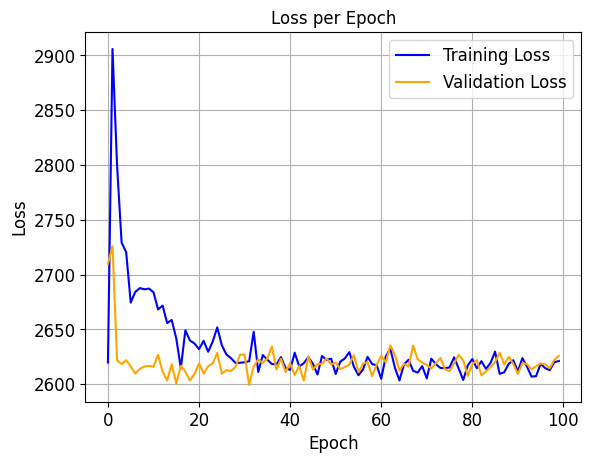

In [14]:
import matplotlib.pyplot as plt

# Configuración de estilos para la gráfica
plt.rc('font', size=12)          # Tamaño predeterminado del texto
plt.rc('axes', titlesize=12)     # Tamaño de fuente para el título de los ejes
plt.rc('axes', labelsize=12)     # Tamaño de fuente para las etiquetas de los ejes (x e y)
plt.rc('xtick', labelsize=12)    # Tamaño de fuente para las etiquetas del eje x
plt.rc('ytick', labelsize=12)    # Tamaño de fuente para las etiquetas del eje y
plt.rc('legend', fontsize=12)    # Tamaño de fuente para la leyenda
plt.rc('figure', titlesize=12)   # Tamaño de fuente para el título de la figura

# Graficar las pérdidas
if losses and v_losses:  # Asegurarse de que las listas no estén vacías
    plt.plot(losses, label='Training Loss', color='blue')
    plt.plot(v_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No hay datos de pérdidas para graficar.")
    

In [15]:
# Definir los caracteres o tokens musicales basados en los datos MIDI
char_to_idx = {
    '<start>': 0,
    '<end>': 1,
    'pitch_60': 2,
    'step_1': 3,
    'duration_1': 4,
    'velocity_60': 5,
}

idx_to_char = {v: k for k, v in char_to_idx.items()}

In [18]:
def write_song(model, prime_str='<start>', max_len=1000, temp=0.8):
    """
    Generates a new sequence of music based on a start string and a trained model.
    """
    model.eval()  # Set the model to evaluation mode

    # Unwrap the model if it's wrapped in DataParallel
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    # Initialize hidden state with batch_size=1
    hidden = model.init_hidden(batch_size=1)

    # Convert prime_str to a list of indices using char_to_idx
    try:
        prime_seq = [char_to_idx[char] for char in prime_str.split()]
    except KeyError as e:
        print(f"Character '{e}' not found in char_to_idx. Ensure it is added.")
        return None

    prime_seq = torch.tensor(prime_seq, dtype=torch.long).unsqueeze(0)  # Add batch dimension

    creation = prime_str

    # Pass through the prime sequence
    for i in range(len(prime_seq[0]) - 1):
        _, hidden = model(prime_seq[:, i:i+1], hidden)  # Forward pass through prime sequence

    # Generate the new music sequence
    for j in range(max_len):
        out, hidden = model(prime_seq[:, -1:], hidden)

        # Ensure LSTM hidden state dimensions are correct (2D for unbatched input)
        if isinstance(hidden, tuple):
            hx, cx = hidden

            # Fix the hidden state dimensions if they are 3D instead of 2D
            if hx.dim() == 3:
                hx = hx.squeeze(1)  # Remove the extra dimension
                cx = cx.squeeze(1)
                hidden = (hx, cx)

            print(f"hx shape after squeezing: {hx.shape}")
            print(f"cx shape after squeezing: {cx.shape}")

        # Flatten the output and compute the probability distribution
        out = out.squeeze().cpu().data.numpy()
        out = np.exp(out / temp)
        dist = out / np.sum(out)

        # Choose the next character based on the probability distribution
        next_char_idx = np.random.choice(len(dist), p=dist)
        next_char = idx_to_char.get(next_char_idx, '<unk>')

        creation += ' ' + next_char

        # Break if we encounter the end token
        if next_char == '<end>':
            break

        # Add the next character's index to the prime sequence
        prime_seq = torch.cat([prime_seq, torch.tensor([[next_char_idx]], dtype=torch.long)], dim=1)

    return creation


In [19]:
# Uso del modelo y configuración
config = get_config()  # Get model configuration
print(f"Model configuration: {config}")  # Print model configuration for verification

model = create_model(config)  # Create the model
print(f"Model created: {model}")  # Print model to verify creation

# Intentar generar la canción
generated_song = write_song(model, prime_str='<start>', max_len=1000, temp=0.8)

# Verificar si la canción fue generada correctamente y imprimir
if generated_song:
    print(f"Generated song:\n{generated_song}")
else:
    print("Song generation failed.")


Model configuration: {'save_every': 20, 'seq_size': 25, 'random_seed': 11, 'validation_size': 0.2, 'learning_rate': 0.1, 'n_epochs': 100, 'num_layers': 4, 'hidden_size': 250, 'dropout_p': 0.1, 'model_type': 'lstm', 'batch_size': 150, 'input_size': 4, 'output_size': 4, 'device': 'cpu'}
Model created: MusicRNN(
  (rnn): LSTM(4, 250, num_layers=4, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=250, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Initial hidden state h0 shape: torch.Size([4, 1, 250])
Initial cell state c0 shape: torch.Size([4, 1, 250])


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [17]:
def generate_heatmap(model, char_idx, seq_to_tensor):
    """
    Genera un heatmap basado en las activaciones del modelo para cada característica musical MIDI.
    
    Args:
        model: El modelo entrenado.
        char_idx: Lista de características o tokens musicales.
        seq_to_tensor: Función que convierte un carácter o secuencia a tensor.
    
    Returns:
        np.ndarray: Un heatmap con las activaciones para cada neurona y característica musical.
    """
    num_neurons = model.hidden_size
    num_chars = len(char_idx)
    
    heatmap = np.zeros((num_neurons, num_chars))
    
    for neuron_idx in range(num_neurons):
        for j, char in enumerate(char_idx):
            char_tensor = seq_to_tensor([char])
            out, _ = model(char_tensor)
            heatmap[neuron_idx, j] = out.data.view(-1)[neuron_idx].item()
    
    return heatmap

# Llamar a la función para generar el heatmap
heatmap = generate_heatmap(model, char_idx, seq_to_tensor)

# Configuración del heatmap
plt.figure(figsize=(10, 10))
plt.title("Heatmap For Music RNN")
plt.xlabel("Characteristic")
plt.ylabel("Neuron ID")
plt.imshow(heatmap, cmap='RdBu_r', vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.show()


NameError: name 'char_idx' is not defined

In [24]:
# Función para obtener la configuración
def get_config():
    config = {
        'save_every': 20,
        'seq_size': 25,
        'random_seed': 11,
        'validation_size': 0.20,
        'learning_rate': 1e-1,
        'n_epochs': 100,
        'num_layers': 4,
        'hidden_size': 280,
        'dropout_p': 0.1,
        'model_type': 'lstm',
        'batch_size': 150,
        'input_size': 4,
        'output_size': 4
    }
    torch.manual_seed(config['random_seed'])
    return config

# Definir el modelo
def create_model(config):
    return MusicRNN(
        input_size=config['input_size'],
        hidden_size=config['hidden_size'],
        output_size=config['output_size'],
        model=config['model_type'],
        num_layers=config['num_layers'],
        dropout_p=config['dropout_p']
    )

# Clase del modelo MusicRNN
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model='lstm', num_layers=4, dropout_p=0.1):
        super(MusicRNN, self).__init__()
        self.model = model
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        if self.model == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p)
        elif self.model == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p)
        else:
            raise NotImplementedError(f"Modelo '{self.model}' no soportado.")

        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, hidden):
        rnn_out, hidden = self.rnn(x, hidden)
        rnn_out = self.dropout(rnn_out)
        output = self.fc(rnn_out)
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == 'lstm':
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size))
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Función para escribir canciones
def write_song(model, prime_str='<start>', max_len=1000, temp=0.8):
    """
    Genera una nueva secuencia de música basada en un inicio y un modelo entrenado.
    """
    hidden = model.init_hidden(batch_size=1)  # Inicializamos el estado oculto para un batch_size=1
    
    # Convertir prime_str a una lista de índices usando char_to_idx
    try:
        prime_seq = [char_to_idx[char] for char in prime_str.split()]
    except KeyError as e:
        print(f"Character '{e}' not found in char_to_idx. Ensure it is added.")
        return None
    
    prime_seq = torch.tensor(prime_seq, dtype=torch.long).unsqueeze(0)  # Asegúrate de que sea un tensor con dimensión batch (batch_size=1)
    
    creation = prime_str
    for i in range(len(prime_seq[0]) - 1):
        _, hidden = model(prime_seq[:, i:i+1], hidden)  # Pasar el prime_str para inicializar el estado oculto
    
    for j in range(max_len):
        out, hidden = model(prime_seq[:, -1:], hidden)
        
        # Asegúrate de ajustar el estado oculto a las dimensiones correctas
        if isinstance(hidden, tuple):  # LSTM retorna un tuple (hx, cx)
            hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))  # Eliminamos la dimensión extra
        else:
            hidden = hidden.squeeze(1)  # Si es GRU
        
        out = out.view(-1).cpu().data.numpy()
        out = np.exp(out / temp)
        dist = out / np.sum(out)  # Normalizar
        
        # Elegir el siguiente token basado en la distribución
        next_char_idx = np.random.choice(len(dist), p=dist)
        next_char = idx_to_char[next_char_idx]
        
        creation += ' ' + next_char  # Asegúrate de agregar un espacio entre tokens
        
        if next_char == '<end>':
            break
    
    return creation

# Uso del modelo y configuración
config = get_config()
model = create_model(config)

# Intentar generar la canción
generated_song = write_song(model, prime_str='<start>', max_len=1000, temp=0.8)
if generated_song:
    print(generated_song)


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors